# Задача

Создать модель оценки стоимости автомобиля по его объявлению на сервисе Авто.ру. Модель на вход должна получать объявление, а на выходе выдавать диапазон цен (price_min, price_max).

## Описание

1. Подготовка данных для обучения модели: парсинг данных с объявлений на сайте на примере марки BMW
2. Обработка полученных данных, удаление пропусков и дубликатов.
3. Предобработка данных, заполнение пропущенных значений.
4. Feature Engineering.
5. EDA, работа с выбросами, One-Hot Encoding.
6. Сравнение результатов различных алгоритмов: RandomForest, LightGBM, CatBoost
7. Выводы

### 1. Парсинг данных

In [1]:
import requests

from bs4 import BeautifulSoup

import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib as plt

from random import randint

from time import sleep

from IPython.display import display
pd.options.display.max_columns = None

Для примера мы хотим предсказывать диапазон цен для автомобиля марки BMW. Для обучения модели разумнее спарсить данные со всех объявлений автомобилей BMW на сайте. Если парсить из раздела https://auto.ru/cars/bmw/all/ , то получится спарсить не все объявления, так как на одну страницу попадает только 38 объявлений, а всего страниц в выдаче 99. При этом количество всех объявлений для BMW более 20 000. Поэтому соберем ссылки на разделы для самых популярных моделей BMW и затем будем парсить отдельно для каждой модели:

In [2]:
url_bmw = 'https://auto.ru/cars/bmw/all/'

soup_bmw = BeautifulSoup(requests.get(url_bmw).content.decode('utf-8'), 'html.parser')

bmw_models = [link.attrs['href'] for link in soup_bmw.find_all('a', class_='ListingPopularMMM-module__itemName')]

bmw_models

['https://auto.ru/cars/bmw/1er/all/',
 'https://auto.ru/cars/bmw/3er/all/',
 'https://auto.ru/cars/bmw/5er/all/',
 'https://auto.ru/cars/bmw/6er/all/',
 'https://auto.ru/cars/bmw/7er/all/',
 'https://auto.ru/cars/bmw/x1/all/',
 'https://auto.ru/cars/bmw/x3/all/',
 'https://auto.ru/cars/bmw/x4/all/',
 'https://auto.ru/cars/bmw/x5/all/',
 'https://auto.ru/cars/bmw/x6/all/',
 'https://auto.ru/cars/bmw/x7/all/']

Напишем вспомогательную функцию, которая парсит ссылки на объявления для каждой модели:

In [3]:
def getPageAds(url):
    ads = []
    url += '?page='
    #print(url)
    for i in range(1,100):
        url_parsing = url+str(i)
        #print(url_parsing)
        try:
            response = requests.get(url_parsing) 
            soup = BeautifulSoup(response.content.decode('utf-8'), 'html.parser')
            links = [link.attrs['href'] for link in soup.find_all('a', class_='Link ListingItemThumb')]
            for link in links:
                ads.append(link)
        except:
            break
        
        # делаем задержку перед парсингом объявлений со следующей страницы, чтобы запросы к серверу не шли слишком часто
        sleep(randint(1,2))
    return ads

А также функцию, которая парсит данные с конкретного объявления:

In [4]:
def getAutoInfo(url):
    info = {}
    soup = BeautifulSoup(requests.get(url).content, 'html.parser') 
    
    # год выпуска автомобиля
    try:
        release_year = soup.find('li', class_='CardInfo__row CardInfo__row_year').find_all('span', class_='CardInfo__cell')[1].text
    except:
        release_year = None
    info['release_year'] =  release_year
    
    # пробег автомобиля в км   
    try:
        kmAge = soup.find('li', class_='CardInfo__row CardInfo__row_kmAge').find_all('span', class_='CardInfo__cell')[1].text.replace(u"\xa0",u" ").replace(' ','')[:-2]
    except:
        kmAge = None
    info['kmAge'] = kmAge
    
    # кузов
    try:
        bodytype = soup.find('li', class_='CardInfo__row CardInfo__row_bodytype').find_all('span', class_='CardInfo__cell')[1].text
    except:
        bodytype = None
    info['bodytype'] = bodytype
    
    # цвет    
    try:
        color = soup.find('li', class_='CardInfo__row CardInfo__row_color').find_all('span', class_='CardInfo__cell')[1].text
    except:
        color = None
    info['color'] = color
    
    # двигатель
    try:
        engine = soup.find('li', class_='CardInfo__row CardInfo__row_engine').find_all('span', class_='CardInfo__cell')[1].text.replace(u"\xa0",u" ")
    except:
        engine = None
    info['engine'] = engine    
    
    # коробка передач
    try:
        transmission = soup.find('li', class_='CardInfo__row CardInfo__row_transmission').find_all('span', class_='CardInfo__cell')[1].text
    except:
        transmission = None
    info['transmission'] = transmission
    
    # привод
    try:
        drive = soup.find('li', class_='CardInfo__row CardInfo__row_drive').find_all('span', class_='CardInfo__cell')[1].text
    except:
        drive = None
    info['drive'] = drive
    
    # руль
    try:
        wheel = soup.find('li', class_='CardInfo__row CardInfo__row_wheel').find_all('span', class_='CardInfo__cell')[1].text
    except:
        wheel = None
    info['wheel'] = wheel
    
    # число владельцев
    try:
        ownersCount = soup.find('li', class_='CardInfo__row CardInfo__row_ownersCount').find_all('span', class_='CardInfo__cell')[1].text.replace(u"\xa0",u" ")
    except:
        ownersCount = None
    info['ownersCount'] = ownersCount
    
    # время владения
    try:
        owningTime = soup.find('li', class_='CardInfo__row CardInfo__row_owningTime').find_all('span', class_='CardInfo__cell')[1].text
    except:
        owningTime = None
    info['owningTime'] = owningTime
    
    # ПТС (паспорт транспортного средства)
    try:
        pts = soup.find('li', class_='CardInfo__row CardInfo__row_pts').find_all('span', class_='CardInfo__cell')[1].text
    except:
        pts = None
    info['ПТС'] = pts
    
    # Таможня
    try:
        customs = soup.find('li', class_='CardInfo__row CardInfo__row_customs').find_all('span', class_='CardInfo__cell')[1].text
    except:
        customs = None
    info['Таможня'] = customs
    
    # Состояние
    try:
        state = soup.find('li', class_='CardInfo__row CardInfo__row_state').find_all('span', class_='CardInfo__cell')[1].text
    except:
        state = None
    info['Состояние'] = state
    
    #парсинг блока с комплектацией
    try:
        equipment = soup.find(string = re.compile("equipmentGroups"))
        start_index = equipment.find('"equipmentGroups"') + 18
        end_index = equipment.find('"lk_summary"') - 2
        info['equipment'] = equipment[start_index:end_index]
    except:
        info['equipment'] = None
    
    # цена автомобиля
    try:
        price = soup.find('span', class_="OfferPriceCaption__price").text.replace(u"\xa0",u" ").replace(' ','')[:-1]
    except:
        price = None
    info['price'] = price
    
    # url объявления
    info['url'] = url
    
    return info

Пример работы функции на одном из объявлений:

In [5]:
getAutoInfo('https://auto.ru/cars/used/sale/bmw/x6/1098318268-ac807fe6/')

{'release_year': '2016',
 'kmAge': '108000',
 'bodytype': 'внедорожник 5 дв.',
 'color': 'белый',
 'engine': '3.0 л / 249 л.с. / Дизель',
 'transmission': 'автоматическая',
 'drive': 'полный',
 'wheel': 'Левый',
 'ownersCount': '1 владелец',
 'owningTime': '4 года и 2 месяца',
 'ПТС': 'Оригинал',
 'Таможня': 'Растаможен',
 'Состояние': 'Не требует ремонта',
 'equipment': None,
 'price': '2800000',
 'url': 'https://auto.ru/cars/used/sale/bmw/x6/1098318268-ac807fe6/'}

Все данные будем собирать в датафрейм для дальнейшей работы. Создадим датафрейм и через цикл будем добавлять в него данные с каждого объявления.

In [6]:
#df = pd.DataFrame(columns=['release_year','kmAge','bodytype','color','engine','transmission',
#                          'drive','wheel','ownersCount','owningTime',
#                         'ПТС','Таможня','Состояние','equipment','price','url'])

#for bmw_model in bmw_models:
#    ads = getPageAds(bmw_model)
#    for ad in ads:
#        row = getAutoInfo(ad)
#        sleep(randint(1,2))
#        df = df.append(row, ignore_index=True)

Данный процесс занимает достаточно продолжительное время. В результате получаем вот такой датафрейм:

In [7]:
df = pd.read_csv('bmw_train.csv')

df.sample(5)

,release_year,kmAge,bodytype,color,engine,transmission,drive,wheel,ownersCount,owningTime,ПТС,Таможня,Состояние,equipment,price,url
8575,1991.0,345000.0,седан,чёрный,2.0 л / 150 л.с. / Бензин,механическая,задний,Левый,3 или более,NaN,Дубликат,Растаможен,Не требует ремонта,NaN,100000,https://auto.ru/cars/used/sale/bmw/5er/1098241...
19765,2011.0,217000.0,внедорожник 5 дв.,красный,3.0 л / 306 л.с. / Дизель,автоматическая,полный,Левый,3 или более,NaN,Оригинал,Растаможен,Не требует ремонта,"[{""name"":""Безопасность"",""values"":[""Система ста...",1552000,https://auto.ru/cars/used/sale/bmw/x6/10937436...
16242,2012.0,197000.0,внедорожник 5 дв.,чёрный,3.0 л / 245 л.с. / Дизель,автоматическая,полный,Левый,1 владелец,7 лет и 10 месяцев,Оригинал,Растаможен,Не требует ремонта,"[{""name"":""Прочее"",""values"":[""Защита картера"",""...",1440000,https://auto.ru/cars/used/sale/bmw/x5/10901704...
11616,2012.0,171000.0,внедорожник 5 дв.,коричневый,2.0 л / 150 л.с. / Бензин,автоматическая,задний,Левый,3 или более,3 года и 5 месяцев,Оригинал,Растаможен,Не требует ремонта,"[{""name"":""Безопасность"",""values"":[""Антипробукс...",740000,https://auto.ru/cars/used/sale/bmw/x1/10643347...
16288,2008.0,300000.0,внедорожник 5 дв.,чёрный,3.0 л / 235 л.с. / Дизель,автоматическая,полный,Левый,3 или более,3 года,Оригинал,Растаможен,Не требует ремонта,"[{""name"":""Безопасность"",""values"":[""Антипробукс...",1140000,https://auto.ru/cars/used/sale/bmw/x5/10860543...


### 2. Обработка полученных данных, удаление дубликатов

Проверим наличие дубликатов (они могли появиться, так как при парсинге интернет-соединение несколько раз пропадало и приходилось парсить заново определенный раздел):

In [8]:
df.duplicated().sum()

648

Избавимся от них:

In [9]:
df = df.drop_duplicates().reset_index(drop=True)
df

,release_year,kmAge,bodytype,color,engine,transmission,drive,wheel,ownersCount,owningTime,ПТС,Таможня,Состояние,equipment,price,url
0,2006.0,203000.0,хэтчбек 5 дв.,голубой,2.0 л / 129 л.с. / Бензин,автоматическая,задний,Левый,3 или более,4 месяца,Оригинал,Растаможен,Не требует ремонта,"[{""name"":""Безопасность"",""values"":[""Система ста...",399700,https://auto.ru/cars/used/sale/bmw/1er/1097050...
1,2007.0,201000.0,хэтчбек 5 дв.,чёрный,2.0 л / 129 л.с. / Бензин,автоматическая,задний,Левый,3 или более,NaN,Оригинал,Растаможен,Не требует ремонта,"[{""name"":""Комфорт"",""values"":[""Запуск двигателя...",365000,https://auto.ru/cars/used/sale/bmw/1er/1099333...
2,2008.0,141788.0,хэтчбек 3 дв.,чёрный,1.6 л / 115 л.с. / Бензин,автоматическая,задний,Левый,3 или более,NaN,Дубликат,Растаможен,Не требует ремонта,NaN,448000,https://auto.ru/cars/used/sale/bmw/1er/1099438...
3,2007.0,127200.0,хэтчбек 5 дв.,синий,2.0 л / 150 л.с. / Бензин,автоматическая,задний,Левый,3 или более,NaN,Оригинал,Растаможен,Не требует ремонта,"[{""name"":""Комфорт"",""values"":[""Круиз-контроль"",...",415000,https://auto.ru/cars/used/sale/bmw/1er/1098730...
4,2013.0,88000.0,хэтчбек 3 дв.,оранжевый,3.0 л / 320 л.с. / Бензин,автоматическая,полный,Левый,3 или более,1 год и 2 месяца,Дубликат,Растаможен,Не требует ремонта,"[{""name"":""Комфорт"",""values"":[""Круиз-контроль"",...",1400000,https://auto.ru/cars/used/sale/bmw/1er/1099533...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Безопасность"",""values"":[""Антипробукс...",от6899200,https://auto.ru/cars/new/group/bmw/x7/21406262...
19453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Безопасность"",""values"":[""Антипробукс...",от7415000,https://auto.ru/cars/new/group/bmw/x7/21406262...
19454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Безопасность"",""values"":[""Антипробукс...",от7089200,https://auto.ru/cars/new/group/bmw/x7/21406260...
19455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Комфорт"",""values"":[""Круиз-контроль"",...",8715600,https://auto.ru/cars/new/group/bmw/x7/21406262...


Ошибочно спарсились ссылки на группы объявлений (url содержит group), удалим эти строки:

In [10]:
df[df.url.str.contains('group')]

,release_year,kmAge,bodytype,color,engine,transmission,drive,wheel,ownersCount,owningTime,ПТС,Таможня,Состояние,equipment,price,url
950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Комфорт"",""values"":[""Круиз-контроль"",...",3500000,https://auto.ru/cars/new/group/bmw/3er/2079612...
955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Комфорт"",""values"":[""Круиз-контроль"",...",от2720000,https://auto.ru/cars/new/group/bmw/3er/2079588...
966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Комфорт"",""values"":[""Круиз-контроль"",...",3303400,https://auto.ru/cars/new/group/bmw/3er/2160551...
971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Комфорт"",""values"":[""Круиз-контроль"",...",2954100,https://auto.ru/cars/new/group/bmw/3er/2159242...
977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Комфорт"",""values"":[""Круиз-контроль"",...",3303400,https://auto.ru/cars/new/group/bmw/3er/2160551...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Безопасность"",""values"":[""Антипробукс...",от6899200,https://auto.ru/cars/new/group/bmw/x7/21406262...
19453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Безопасность"",""values"":[""Антипробукс...",от7415000,https://auto.ru/cars/new/group/bmw/x7/21406262...
19454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Безопасность"",""values"":[""Антипробукс...",от7089200,https://auto.ru/cars/new/group/bmw/x7/21406260...
19455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{""name"":""Комфорт"",""values"":[""Круиз-контроль"",...",8715600,https://auto.ru/cars/new/group/bmw/x7/21406262...


In [11]:
df = df[~(df.url.str.contains('group'))]
df.isnull().sum()

release_year       0
kmAge              0
bodytype           0
color              0
engine             0
transmission       0
drive              0
wheel              0
ownersCount        6
owningTime      9964
ПТС                0
Таможня            0
Состояние          0
equipment       6277
price             49
url                0
dtype: int64

### 3. Предобработка данных, заполнение пропущенных значений.

Пропуски остались только в 3 колонках: owningTime - время владения автомобилем, equipment - комплектация автомобиля, price - цена автомобиля. Посмотрим на строки, где пропущено значение цены:

In [12]:
df[df.price.isnull()].iloc[1].url

'https://auto.ru/cars/used/sale/bmw/1er/1099500042-9c4092f9/'

Если перейти по ссылке, то оказывается, что "Автомобиль уже продан. Объявление доступно только по прямой ссылке". Пока парсили, кто-то уже успел продать автомобиль. Поздравляем их с продажей. 

In [13]:
df.dropna(subset=['price'], inplace=True)

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
df = df.reset_index(drop=True)

Остались только пропуски в колонках owningTime и equipment. В колонке equipment заменим пропуски пустым списком:

In [15]:
df.equipment = df.equipment.fillna('[]')

Для заполнения пропусков в owningTime посмотрим на распределение значений:

In [16]:
df['owningTime'].value_counts()[:50]

11 месяцев             144
1 год и 8 месяцев      128
1 год и 9 месяцев      125
1 год и 2 месяца       125
1 год и 11 месяцев     122
1 год и 1 месяц        120
1 год и 4 месяца       118
9 месяцев              117
10 месяцев             115
2 года и 1 месяц       115
1 год и 3 месяца       114
1 год и 7 месяцев      114
1 год и 10 месяцев     108
2 года                 108
7 месяцев              107
1 год                  102
2 года и 7 месяцев     102
8 месяцев               97
1 год и 6 месяцев       92
2 года и 2 месяца       92
2 года и 10 месяцев     90
1 год и 5 месяцев       90
2 года и 4 месяца       88
3 года и 1 месяц        87
3 года и 4 месяца       87
3 года и 2 месяца       84
3 года и 3 месяца       81
2 года и 3 месяца       81
2 года и 9 месяцев      81
5 лет и 7 месяцев       81
2 года и 6 месяцев      80
2 года и 11 месяцев     79
2 года и 5 месяцев      78
6 месяцев               75
2 года и 8 месяцев      74
3 года                  72
3 года и 5 месяцев      69
4

Напишем вспомогательную функцию, которая переводит значения в колонке owningTime в количество месяцев:

In [17]:
import re

def time_to_months(x):
    numbers = re.compile('\d.').findall(str(x))
    if len(numbers)>1:
        return (int(numbers[0])*12 + int(numbers[1]))
    elif ('лет' in x)|('год' in x)|('года' in x):
        return int(numbers[0])*12
    else:
        return int(numbers[0])
    
df['owningTime'] = df['owningTime'].fillna('0 месяцев').apply(time_to_months)

df['owningTime'].value_counts()

0      9937
11      144
20      128
21      125
14      125
       ... 
210       1
178       1
155       1
171       1
207       1
Name: owningTime, Length: 204, dtype: int64

In [18]:
df.isnull().sum()

release_year    0
kmAge           0
bodytype        0
color           0
engine          0
transmission    0
drive           0
wheel           0
ownersCount     6
owningTime      0
ПТС             0
Таможня         0
Состояние       0
equipment       0
price           0
url             0
dtype: int64

### 4. Feature Engineering

В значениях колонки engine содержится сразу 3 признака - объем двигателя, мощность двигателя, тип топлива. Создадим для них отдельные колонки:

#### 1. Объем двигателя

In [19]:
df['engineDisplacement'] = df['engine'].apply(lambda x: x[:3])
df['engineDisplacement'].value_counts()

3.0    6245
2.0    5335
2.5    1328
4.4    1132
1.6     885
4.8     427
2.2     195
1.8     175
1.9     157
1.5     142
2.8     141
2.9      62
3.5      60
4.0      52
3.6      48
3.4      33
6.0      32
4.6      20
5.4      18
2.4      16
3.9       7
6.6       5
5.0       5
3.2       4
2.3       4
1.7       2
Name: engineDisplacement, dtype: int64

#### 2. Мощность двигателя (в л.с.)

In [20]:
df['enginePower'] = df['engine'].apply(lambda x: x[8:11])
df['enginePower'].value_counts()

184    1798
306    1253
218    1100
249     953
150     918
       ... 
449       1
86        1
304       1
243       1
387       1
Name: enginePower, Length: 75, dtype: int64

#### 3. Тип топлива

In [21]:
df['fuelType'] = df['engine'].apply(lambda x: str(re.compile('[А-Я][а-я]*').findall(str(x))[0]))
df['fuelType'].value_counts()

Бензин    11582
Дизель     4923
Гибрид       25
Name: fuelType, dtype: int64

В колонке equipment содержится словарь - комплектация автомобиля:

In [22]:
import json

json.loads(df['equipment'][0])[0]['values']

['Система стабилизации (ESP)',
 'Подушка безопасности водителя',
 'Подушка безопасности пассажира',
 'Подушки безопасности боковые',
 'Антиблокировочная система (ABS)']

In [23]:
complect = set()

for i in range(0,df.shape[0],1):
    try:
        equipment = json.loads(df['equipment'][i])
        # начинаем перебор всех атрибутов в строке с комплектацией
        for feature in equipment: 
            #print(feature)
            # для каждого атрибута комплектации проходим по каждому элементу и добавляем отсутствующий элемент в коллекцию
            for i in range(len(feature['values'])): 
                complect.add(feature['values'][i])
    except:
        continue
        
len(complect)

176

У нас появилось дополнительно 176 признаков - наличие у автомобиля того или иного компонента комплектации:

In [24]:
def find_item(cell):
    if item in cell:
        return 1
    return 0

for item in complect:
    df[item] = df['equipment'].apply(find_item)
    
df.sample(5)

,release_year,kmAge,bodytype,color,engine,transmission,drive,wheel,ownersCount,owningTime,ПТС,Таможня,Состояние,equipment,price,url,engineDisplacement,enginePower,fuelType,Декоративные накладки на педали,Легкосплавные диски,ЭРА-ГЛОНАСС,Bluetooth,Регулировка руля по вылету,Премиальная аудиосистема,Искусственная кожа (Материал салона),Диски 17,Подушка безопасности пассажира,Солнцезащитные шторки в задних дверях,Яндекс.Авто,Датчик проникновения в салон (датчик объема),Электрообогрев зоны стеклоочистителей,Иммобилайзер,Аэрография,Android Auto,Система ночного видения,Розетка 12V,Электрорегулировка сиденья водителя,Защита картера,Подрулевые лепестки переключения передач,Аудиоподготовка,Система контроля за полосой движения,Мультимедиа система с ЖК-экраном,Память сиденья водителя,Климат-контроль многозонный,AUX,Рейлинги на крыше,Активная подвеска,Центральный замок,Открытие багажника без помощи рук,Лазерные фары,Комбинированный (Материал салона),Третий задний подголовник,Парктроник передний,Регулируемый педальный узел,Количество мест: 5,Электроскладывание зеркал,Спортивные передние сиденья,Солнцезащитная шторка на заднем стекле,Система помощи при старте в гору (HSA),Диски 19,Система помощи при спуске,Память передних сидений,Докатка,Количество мест: 7,Тонированные стекла,Система управления дальним светом,Дистанционный запуск двигателя,Люк,Бронированный кузов,Запуск двигателя с кнопки,Вентиляция задних сидений,Аудиосистема,Система автоматической парковки,Пневмоподвеска,Подушки безопасности боковые задние,Система выбора режима движения,Камера 360°,Спортивная подвеска,Автоматический корректор фар,Накладки на пороги,Электрообогрев боковых зеркал,Обвес кузова,Антипробуксовочная система (ASR),Крепление детского кресла (передний ряд) ISOFIX,Диски 23,Диски 27,Проекционный дисплей,Голосовое управление,Кондиционер,Количество мест: 4,Светлый салон,Электронная приборная панель,Складной столик на спинках передних сидений,Ткань (Материал салона),Система распознавания дорожных знаков,Подушка безопасности водителя,Рулевая колонка с памятью положения,Датчик усталости водителя,Парктроник задний,Функция складывания спинки сиденья пассажира,Фаркоп,Охлаждаемый перчаточный ящик,Светодиодные фары,Доводчик дверей,Подушки безопасности боковые,Мультимедиа система для задних пассажиров,Навигационная система,Диски 15,CarPlay,Сигнализация,Система доступа без ключа,Передний центральный подлокотник,Декоративная подсветка салона,Ламинированные боковые стекла,Подогрев передних сидений,Климат-контроль 2-зонный,Ксеноновые/Биксеноновые фары,Блокировка замков задних дверей,Отделка кожей рычага КПП,Мультифункциональное рулевое колесо,Складывающееся заднее сиденье,Велюр (Материал салона),Камера задняя,Система контроля слепых зон,Кожа (Материал салона),Электрорегулировка задних сидений,Система стабилизации рулевого управления (VSM),Датчик дождя,Сиденья с массажем,Электрорегулировка передних сидений,Третий ряд сидений,Система предотвращения столкновения,Диски 21,Беспроводная зарядка для смартфона,Электропривод крышки багажника,Регулировка сиденья водителя по высоте,Регулировка передних сидений по высоте,Диски 14,Электростеклоподъёмники передние,Активный усилитель руля,Подогрев задних сидений,Диски 12,Декоративные молдинги,Газобаллонное оборудование,Количество мест: 6,Вентиляция передних сидений,Сиденье водителя с поясничной поддержкой,Полноразмерное запасное колесо,Круиз-контроль,Датчик света,Сигнализация с обратной связью,Антиблокировочная система (ABS),Регулировка руля по высоте,Система стабилизации (ESP),Электрообогрев форсунок стеклоомывателей,Электрообогрев лобового стекла,Диски 13,Стальные диски,Противотуманные фары,Система адаптивного освещения,Розетка 220V,Электростеклоподъёмники задние,Тёмный салон,Передние сиденья с поясничной поддержкой,Электрорегулировка руля,Диски 22,Диски 18,Адаптивный круиз-контроль,Датчик давления в шинах,Обогрев рулевого колеса,Подушка безопасности для защиты коленей водителя,Программируемый предпусковой отопитель,Прикуриватель и пепельница,Ом

Заодно можно посчитать сколько всего компонент есть в комплектации:

In [25]:
df['number_of_complects'] = df.iloc[:,-176:].values.sum(axis=1)
df.sample(2)

,release_year,kmAge,bodytype,color,engine,transmission,drive,wheel,ownersCount,owningTime,ПТС,Таможня,Состояние,equipment,price,url,engineDisplacement,enginePower,fuelType,Декоративные накладки на педали,Легкосплавные диски,ЭРА-ГЛОНАСС,Bluetooth,Регулировка руля по вылету,Премиальная аудиосистема,Искусственная кожа (Материал салона),Диски 17,Подушка безопасности пассажира,Солнцезащитные шторки в задних дверях,Яндекс.Авто,Датчик проникновения в салон (датчик объема),Электрообогрев зоны стеклоочистителей,Иммобилайзер,Аэрография,Android Auto,Система ночного видения,Розетка 12V,Электрорегулировка сиденья водителя,Защита картера,Подрулевые лепестки переключения передач,Аудиоподготовка,Система контроля за полосой движения,Мультимедиа система с ЖК-экраном,Память сиденья водителя,Климат-контроль многозонный,AUX,Рейлинги на крыше,Активная подвеска,Центральный замок,Открытие багажника без помощи рук,Лазерные фары,Комбинированный (Материал салона),Третий задний подголовник,Парктроник передний,Регулируемый педальный узел,Количество мест: 5,Электроскладывание зеркал,Спортивные передние сиденья,Солнцезащитная шторка на заднем стекле,Система помощи при старте в гору (HSA),Диски 19,Система помощи при спуске,Память передних сидений,Докатка,Количество мест: 7,Тонированные стекла,Система управления дальним светом,Дистанционный запуск двигателя,Люк,Бронированный кузов,Запуск двигателя с кнопки,Вентиляция задних сидений,Аудиосистема,Система автоматической парковки,Пневмоподвеска,Подушки безопасности боковые задние,Система выбора режима движения,Камера 360°,Спортивная подвеска,Автоматический корректор фар,Накладки на пороги,Электрообогрев боковых зеркал,Обвес кузова,Антипробуксовочная система (ASR),Крепление детского кресла (передний ряд) ISOFIX,Диски 23,Диски 27,Проекционный дисплей,Голосовое управление,Кондиционер,Количество мест: 4,Светлый салон,Электронная приборная панель,Складной столик на спинках передних сидений,Ткань (Материал салона),Система распознавания дорожных знаков,Подушка безопасности водителя,Рулевая колонка с памятью положения,Датчик усталости водителя,Парктроник задний,Функция складывания спинки сиденья пассажира,Фаркоп,Охлаждаемый перчаточный ящик,Светодиодные фары,Доводчик дверей,Подушки безопасности боковые,Мультимедиа система для задних пассажиров,Навигационная система,Диски 15,CarPlay,Сигнализация,Система доступа без ключа,Передний центральный подлокотник,Декоративная подсветка салона,Ламинированные боковые стекла,Подогрев передних сидений,Климат-контроль 2-зонный,Ксеноновые/Биксеноновые фары,Блокировка замков задних дверей,Отделка кожей рычага КПП,Мультифункциональное рулевое колесо,Складывающееся заднее сиденье,Велюр (Материал салона),Камера задняя,Система контроля слепых зон,Кожа (Материал салона),Электрорегулировка задних сидений,Система стабилизации рулевого управления (VSM),Датчик дождя,Сиденья с массажем,Электрорегулировка передних сидений,Третий ряд сидений,Система предотвращения столкновения,Диски 21,Беспроводная зарядка для смартфона,Электропривод крышки багажника,Регулировка сиденья водителя по высоте,Регулировка передних сидений по высоте,Диски 14,Электростеклоподъёмники передние,Активный усилитель руля,Подогрев задних сидений,Диски 12,Декоративные молдинги,Газобаллонное оборудование,Количество мест: 6,Вентиляция передних сидений,Сиденье водителя с поясничной поддержкой,Полноразмерное запасное колесо,Круиз-контроль,Датчик света,Сигнализация с обратной связью,Антиблокировочная система (ABS),Регулировка руля по высоте,Система стабилизации (ESP),Электрообогрев форсунок стеклоомывателей,Электрообогрев лобового стекла,Диски 13,Стальные диски,Противотуманные фары,Система адаптивного освещения,Розетка 220V,Электростеклоподъёмники задние,Тёмный салон,Передние сиденья с поясничной поддержкой,Электрорегулировка руля,Диски 22,Диски 18,Адаптивный круиз-контроль,Датчик давления в шинах,Обогрев рулевого колеса,Подушка безопасности для защиты коленей водителя,Программируемый предпусковой отопитель,Прикуриватель и пепельница,Ом

### 5. EDA, работа с выбросами, One-Hot Encoding

Для категориальных признаков полезно посмотреть на уникальные значения признака:

In [26]:
df.bodytype.unique()

array(['хэтчбек 5 дв.', 'хэтчбек 3 дв.', 'купе', 'кабриолет', 'лифтбек',
       'седан', 'универсал 5 дв.', 'седан 2 дв.', 'внедорожник 5 дв.'],
      dtype=object)

In [27]:
df.color.unique()

array(['голубой', 'чёрный', 'синий', 'оранжевый', 'серый', 'белый',
       'серебристый', 'красный', 'коричневый', 'бежевый', 'золотистый',
       'пурпурный', 'жёлтый', 'зелёный', 'фиолетовый', 'розовый'],
      dtype=object)

#### Какие цвета самые популярные? (Чёрный Бумер)

In [28]:
df.color.value_counts()

чёрный         6615
белый          3091
серый          1848
синий          1672
серебристый    1292
коричневый      655
красный         537
зелёный         285
бежевый         161
голубой         121
пурпурный        84
золотистый       78
оранжевый        47
фиолетовый       34
жёлтый            9
розовый           1
Name: color, dtype: int64

#### Что там с коробкой передач?

In [29]:
df.transmission.value_counts()

автоматическая      15121
механическая         1394
роботизированная       15
Name: transmission, dtype: int64

Какого года выпуска автомобили на механике?

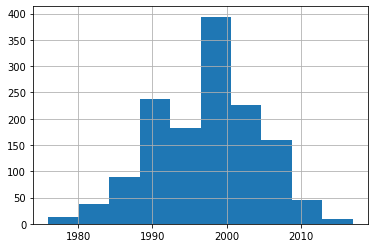

In [30]:
df[df['transmission']=='механическая'].release_year.hist()

Как менялась доля автомобилей с механической коробкой передач с каждым годом?

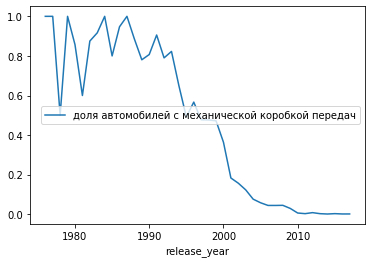

In [31]:
pd.DataFrame(df[df['transmission']=='механическая'].groupby('release_year').transmission.count()/df.groupby('release_year').transmission.count()).rename(columns={'transmission':'доля автомобилей с механической коробкой передач'}).plot()

#### Привод автомобиля:

In [32]:
df['drive'].value_counts()

полный      9493
задний      7005
передний      32
Name: drive, dtype: int64

#### Количество владельцев:

In [33]:
df['ownersCount'].value_counts()

3 или более    9539
2 владельца    3998
1 владелец     2987
Name: ownersCount, dtype: int64

#### Руль:

In [34]:
df['wheel'].value_counts()

Левый     16523
Правый        7
Name: wheel, dtype: int64

#### ПТС:

In [35]:
df['ПТС'].value_counts()

Оригинал    13502
Дубликат     3028
Name: ПТС, dtype: int64

#### Состояние автомобиля:

In [36]:
df['Состояние'].unique()

array(['Не требует ремонта'], dtype=object)

#### Таможня:

In [37]:
df['Таможня'].unique()

array(['Растаможен'], dtype=object)

Все автомобили не требуют ремонта и растоможены, избавимся от этих признаков и признаков, которые не пригодятся для дальнейшей работы:

In [38]:
# на всякий случай создадим копию, чтобы можно было посмотреть url автомобиля

data = df.copy()

data = data.drop(['engine','Таможня','Состояние','equipment','url'], axis=1)
data.sample(5)

,release_year,kmAge,bodytype,color,transmission,drive,wheel,ownersCount,owningTime,ПТС,price,engineDisplacement,enginePower,fuelType,Декоративные накладки на педали,Легкосплавные диски,ЭРА-ГЛОНАСС,Bluetooth,Регулировка руля по вылету,Премиальная аудиосистема,Искусственная кожа (Материал салона),Диски 17,Подушка безопасности пассажира,Солнцезащитные шторки в задних дверях,Яндекс.Авто,Датчик проникновения в салон (датчик объема),Электрообогрев зоны стеклоочистителей,Иммобилайзер,Аэрография,Android Auto,Система ночного видения,Розетка 12V,Электрорегулировка сиденья водителя,Защита картера,Подрулевые лепестки переключения передач,Аудиоподготовка,Система контроля за полосой движения,Мультимедиа система с ЖК-экраном,Память сиденья водителя,Климат-контроль многозонный,AUX,Рейлинги на крыше,Активная подвеска,Центральный замок,Открытие багажника без помощи рук,Лазерные фары,Комбинированный (Материал салона),Третий задний подголовник,Парктроник передний,Регулируемый педальный узел,Количество мест: 5,Электроскладывание зеркал,Спортивные передние сиденья,Солнцезащитная шторка на заднем стекле,Система помощи при старте в гору (HSA),Диски 19,Система помощи при спуске,Память передних сидений,Докатка,Количество мест: 7,Тонированные стекла,Система управления дальним светом,Дистанционный запуск двигателя,Люк,Бронированный кузов,Запуск двигателя с кнопки,Вентиляция задних сидений,Аудиосистема,Система автоматической парковки,Пневмоподвеска,Подушки безопасности боковые задние,Система выбора режима движения,Камера 360°,Спортивная подвеска,Автоматический корректор фар,Накладки на пороги,Электрообогрев боковых зеркал,Обвес кузова,Антипробуксовочная система (ASR),Крепление детского кресла (передний ряд) ISOFIX,Диски 23,Диски 27,Проекционный дисплей,Голосовое управление,Кондиционер,Количество мест: 4,Светлый салон,Электронная приборная панель,Складной столик на спинках передних сидений,Ткань (Материал салона),Система распознавания дорожных знаков,Подушка безопасности водителя,Рулевая колонка с памятью положения,Датчик усталости водителя,Парктроник задний,Функция складывания спинки сиденья пассажира,Фаркоп,Охлаждаемый перчаточный ящик,Светодиодные фары,Доводчик дверей,Подушки безопасности боковые,Мультимедиа система для задних пассажиров,Навигационная система,Диски 15,CarPlay,Сигнализация,Система доступа без ключа,Передний центральный подлокотник,Декоративная подсветка салона,Ламинированные боковые стекла,Подогрев передних сидений,Климат-контроль 2-зонный,Ксеноновые/Биксеноновые фары,Блокировка замков задних дверей,Отделка кожей рычага КПП,Мультифункциональное рулевое колесо,Складывающееся заднее сиденье,Велюр (Материал салона),Камера задняя,Система контроля слепых зон,Кожа (Материал салона),Электрорегулировка задних сидений,Система стабилизации рулевого управления (VSM),Датчик дождя,Сиденья с массажем,Электрорегулировка передних сидений,Третий ряд сидений,Система предотвращения столкновения,Диски 21,Беспроводная зарядка для смартфона,Электропривод крышки багажника,Регулировка сиденья водителя по высоте,Регулировка передних сидений по высоте,Диски 14,Электростеклоподъёмники передние,Активный усилитель руля,Подогрев задних сидений,Диски 12,Декоративные молдинги,Газобаллонное оборудование,Количество мест: 6,Вентиляция передних сидений,Сиденье водителя с поясничной поддержкой,Полноразмерное запасное колесо,Круиз-контроль,Датчик света,Сигнализация с обратной связью,Антиблокировочная система (ABS),Регулировка руля по высоте,Система стабилизации (ESP),Электрообогрев форсунок стеклоомывателей,Электрообогрев лобового стекла,Диски 13,Стальные диски,Противотуманные фары,Система адаптивного освещения,Розетка 220V,Электростеклоподъёмники задние,Тёмный салон,Передние сиденья с поясничной поддержкой,Электрорегулировка руля,Диски 22,Диски 18,Адаптивный круиз-контроль,Датчик давления в шинах,Обогрев рулевого колеса,Подушка безопасности для защиты коленей водителя,Программируемый предпусковой отопитель,Прикуриватель и пепельница,Омыватель фар,Отделка потолка чёрной ткан

#### Что там с распределением значений пробега автомобиля?

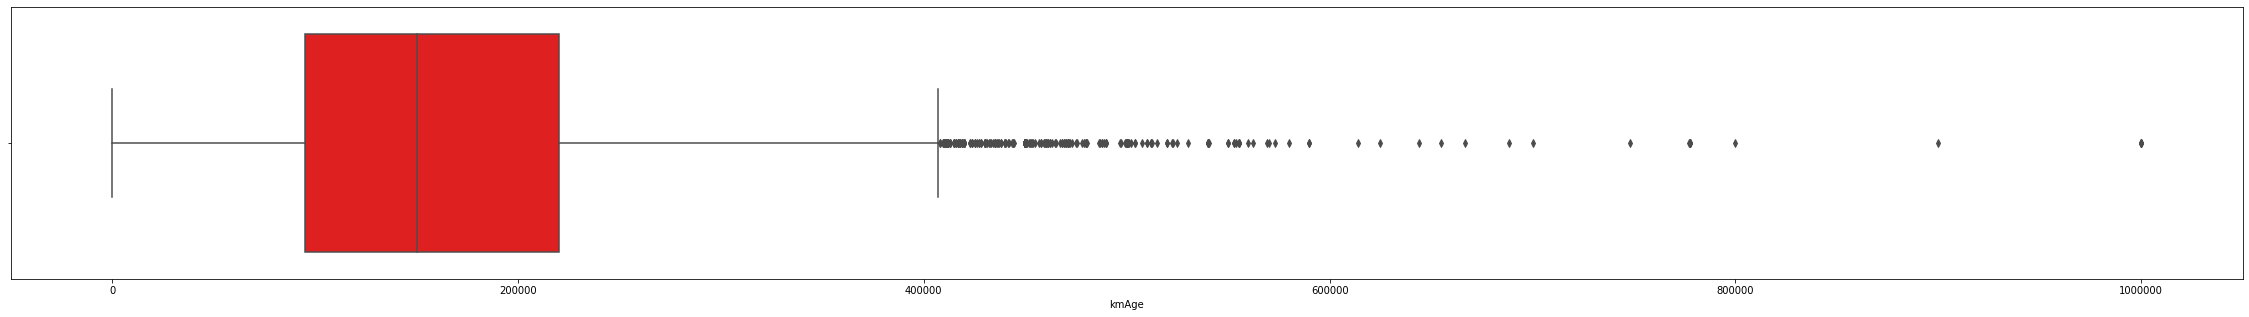

In [39]:
plt.rcParams['figure.figsize']=(40,5)
sns.boxplot(data.kmAge, color='red')

Определим функцию для дальнейшего анализа выбросов. Функция принимает на вход столбец и расчитывает границы выбросов по формуле межквартильного размаха:

In [40]:
def outliers_iqr(column):
    quartile_1, quartile_3 = np.percentile(column, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('Нижняя граница:', lower_bound, 'Верхняя граница:', upper_bound)

In [41]:
outliers_iqr(data.kmAge)

Нижняя граница: -92500.0 Верхняя граница: 407500.0


То есть верхняя граница выбросов лежит примерно в районе 400 000 км. Сколько автомобилей имеют пробег выше этого значения?

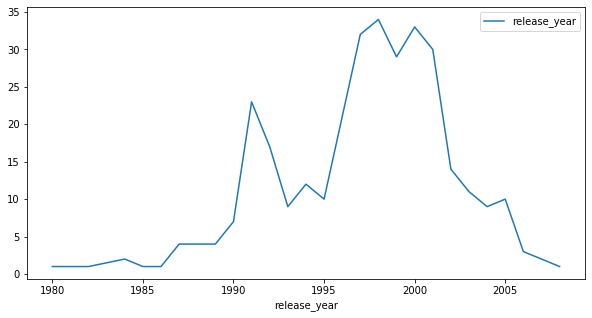

In [42]:
plt.rcParams['figure.figsize']=(10,5)
pd.DataFrame(data.query('kmAge > 400000').groupby('release_year').release_year.count()).plot()

Насколько в среднем отличается цена у этих автомобилей от средней цены остальных автомобилей?

In [43]:
data[data['kmAge'] > 400000].price.mean()

inf

Забыли привести значения в колонке price к типу int:

In [44]:
data['price'] = data['price'].astype('int64')

In [45]:
data[data['kmAge'] < 400000].price.mean() / data[data['kmAge'] >= 400000].price.mean()

4.234992866197051

Более в 4 раза, что и следовало ожидать.

In [46]:
data['enginePower'] = data['enginePower'].astype('int64')
data['engineDisplacement'] = data['engineDisplacement'].astype('float64')

#### Мощность двигателя:

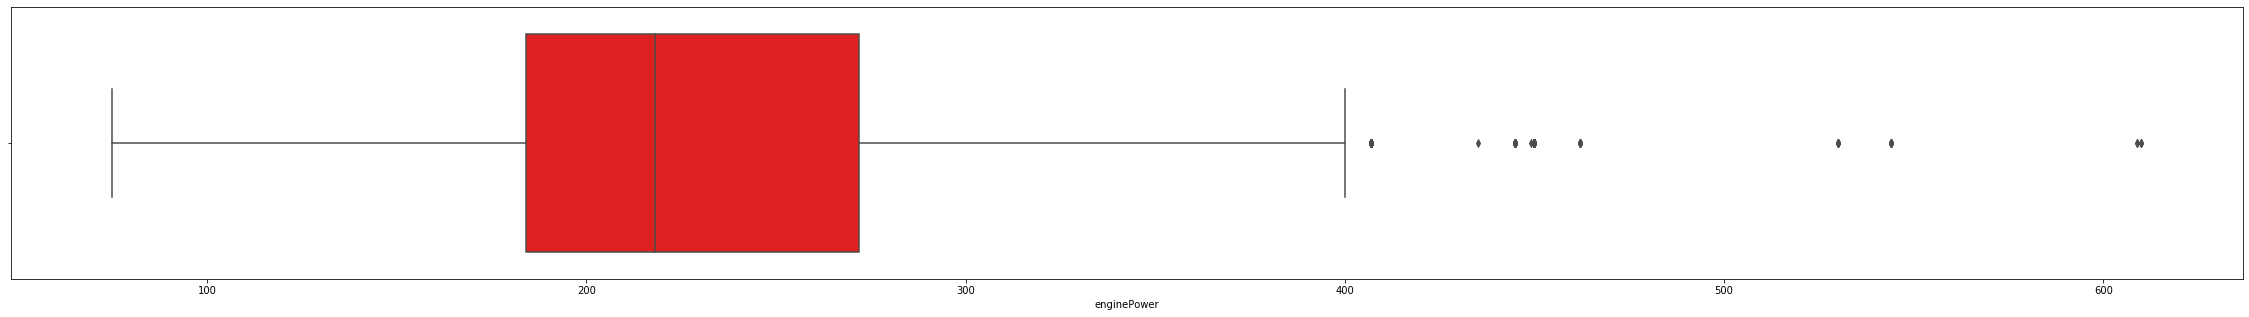

In [47]:
plt.rcParams['figure.figsize']=(40,5)
sns.boxplot(data.enginePower, color='red')

In [48]:
outliers_iqr(data.enginePower)

Нижняя граница: 52.0 Верхняя граница: 404.0


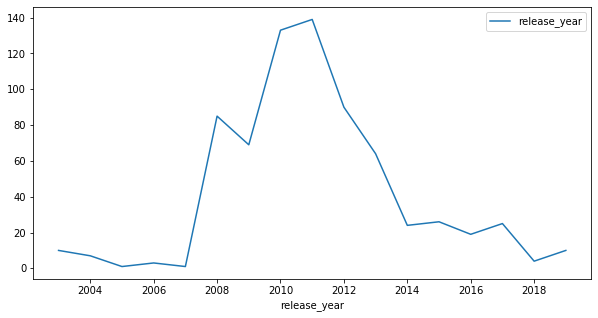

In [49]:
plt.rcParams['figure.figsize']=(10,5)
pd.DataFrame(data.query('enginePower > 400').groupby('release_year').release_year.count()).plot()

In [50]:
data[data['enginePower'] < 400].price.mean() / data[data['enginePower'] >= 400].price.mean()

0.6353668364012395

#### Объем двигателя

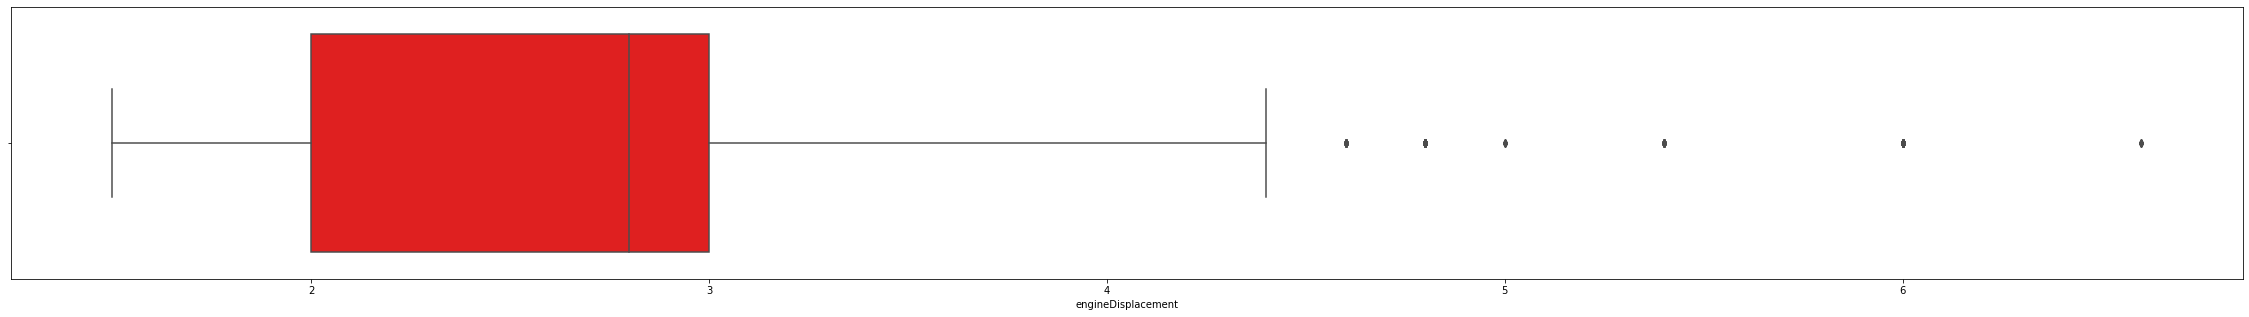

In [51]:
plt.rcParams['figure.figsize']=(40,5)
sns.boxplot(data.engineDisplacement, color='red')

In [52]:
outliers_iqr(data.engineDisplacement)

Нижняя граница: 0.5 Верхняя граница: 4.5


In [53]:
data.query('engineDisplacement > 4.5').engineDisplacement.value_counts()

4.8    427
6.0     32
4.6     20
5.4     18
6.6      5
5.0      5
Name: engineDisplacement, dtype: int64

Интересно, есть ли автомобили с мощностью более 400 л.с. и объемом двигателя от 6?

In [54]:
data.query('engineDisplacement >= 6.0 & enginePower > 400')

,release_year,kmAge,bodytype,color,transmission,drive,wheel,ownersCount,owningTime,ПТС,price,engineDisplacement,enginePower,fuelType,Декоративные накладки на педали,Легкосплавные диски,ЭРА-ГЛОНАСС,Bluetooth,Регулировка руля по вылету,Премиальная аудиосистема,Искусственная кожа (Материал салона),Диски 17,Подушка безопасности пассажира,Солнцезащитные шторки в задних дверях,Яндекс.Авто,Датчик проникновения в салон (датчик объема),Электрообогрев зоны стеклоочистителей,Иммобилайзер,Аэрография,Android Auto,Система ночного видения,Розетка 12V,Электрорегулировка сиденья водителя,Защита картера,Подрулевые лепестки переключения передач,Аудиоподготовка,Система контроля за полосой движения,Мультимедиа система с ЖК-экраном,Память сиденья водителя,Климат-контроль многозонный,AUX,Рейлинги на крыше,Активная подвеска,Центральный замок,Открытие багажника без помощи рук,Лазерные фары,Комбинированный (Материал салона),Третий задний подголовник,Парктроник передний,Регулируемый педальный узел,Количество мест: 5,Электроскладывание зеркал,Спортивные передние сиденья,Солнцезащитная шторка на заднем стекле,Система помощи при старте в гору (HSA),Диски 19,Система помощи при спуске,Память передних сидений,Докатка,Количество мест: 7,Тонированные стекла,Система управления дальним светом,Дистанционный запуск двигателя,Люк,Бронированный кузов,Запуск двигателя с кнопки,Вентиляция задних сидений,Аудиосистема,Система автоматической парковки,Пневмоподвеска,Подушки безопасности боковые задние,Система выбора режима движения,Камера 360°,Спортивная подвеска,Автоматический корректор фар,Накладки на пороги,Электрообогрев боковых зеркал,Обвес кузова,Антипробуксовочная система (ASR),Крепление детского кресла (передний ряд) ISOFIX,Диски 23,Диски 27,Проекционный дисплей,Голосовое управление,Кондиционер,Количество мест: 4,Светлый салон,Электронная приборная панель,Складной столик на спинках передних сидений,Ткань (Материал салона),Система распознавания дорожных знаков,Подушка безопасности водителя,Рулевая колонка с памятью положения,Датчик усталости водителя,Парктроник задний,Функция складывания спинки сиденья пассажира,Фаркоп,Охлаждаемый перчаточный ящик,Светодиодные фары,Доводчик дверей,Подушки безопасности боковые,Мультимедиа система для задних пассажиров,Навигационная система,Диски 15,CarPlay,Сигнализация,Система доступа без ключа,Передний центральный подлокотник,Декоративная подсветка салона,Ламинированные боковые стекла,Подогрев передних сидений,Климат-контроль 2-зонный,Ксеноновые/Биксеноновые фары,Блокировка замков задних дверей,Отделка кожей рычага КПП,Мультифункциональное рулевое колесо,Складывающееся заднее сиденье,Велюр (Материал салона),Камера задняя,Система контроля слепых зон,Кожа (Материал салона),Электрорегулировка задних сидений,Система стабилизации рулевого управления (VSM),Датчик дождя,Сиденья с массажем,Электрорегулировка передних сидений,Третий ряд сидений,Система предотвращения столкновения,Диски 21,Беспроводная зарядка для смартфона,Электропривод крышки багажника,Регулировка сиденья водителя по высоте,Регулировка передних сидений по высоте,Диски 14,Электростеклоподъёмники передние,Активный усилитель руля,Подогрев задних сидений,Диски 12,Декоративные молдинги,Газобаллонное оборудование,Количество мест: 6,Вентиляция передних сидений,Сиденье водителя с поясничной поддержкой,Полноразмерное запасное колесо,Круиз-контроль,Датчик света,Сигнализация с обратной связью,Антиблокировочная система (ABS),Регулировка руля по высоте,Система стабилизации (ESP),Электрообогрев форсунок стеклоомывателей,Электрообогрев лобового стекла,Диски 13,Стальные диски,Противотуманные фары,Система адаптивного освещения,Розетка 220V,Электростеклоподъёмники задние,Тёмный салон,Передние сиденья с поясничной поддержкой,Электрорегулировка руля,Диски 22,Диски 18,Адаптивный круиз-контроль,Датчик давления в шинах,Обогрев рулевого колеса,Подушка безопасности для защиты коленей водителя,Программируемый предпусковой отопитель,Прикуриватель и пепельница,Омыватель фар,Отделка потолка чёрной ткан

Пожалуйста, целых 37 седанов на выбор.

In [55]:
data.query('engineDisplacement >= 6.0 & enginePower > 400').price.mean() / data.price.mean()

1.9103151840494423

И в среднем они в два раза дороже.

#### Цена автомобиля

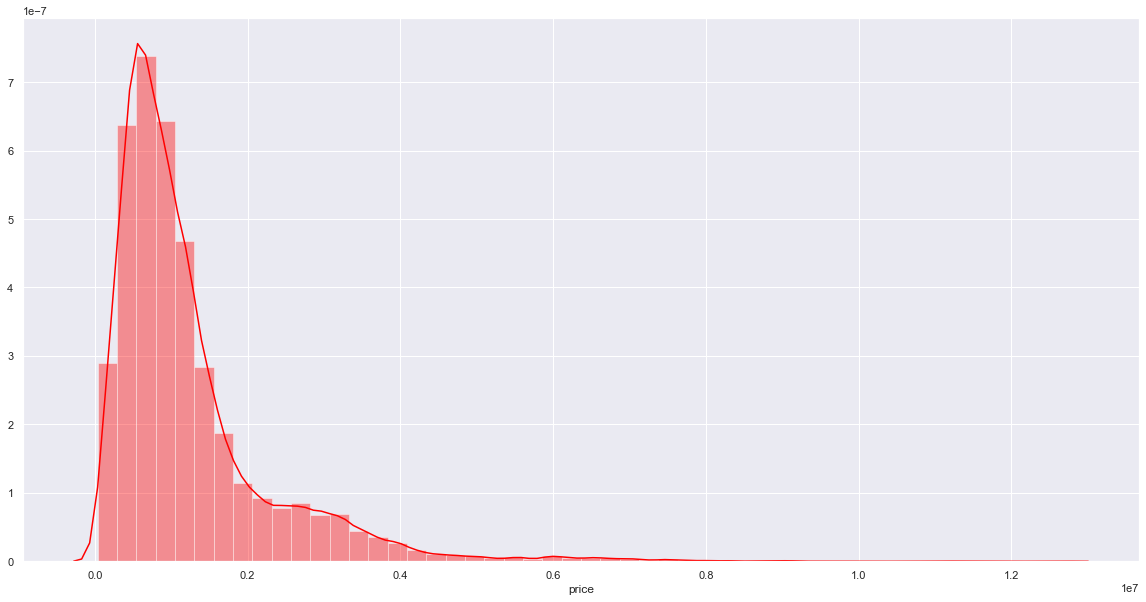

In [56]:
plt.rcParams['figure.figsize']=(20,10)
sns.set();
sns.distplot(data.price, color='red')

#### One-Hot Encoding

Закодируем с помощью dummies категориальные признаки: bodytype, color, transmission, drive, wheel, ownersCount, ПТС, fuelType:

In [57]:
data = pd.get_dummies(data, columns=['bodytype','color','transmission','drive','wheel','ownersCount','ПТС','fuelType'])
data.sample(5)

,release_year,kmAge,owningTime,price,engineDisplacement,enginePower,Декоративные накладки на педали,Легкосплавные диски,ЭРА-ГЛОНАСС,Bluetooth,Регулировка руля по вылету,Премиальная аудиосистема,Искусственная кожа (Материал салона),Диски 17,Подушка безопасности пассажира,Солнцезащитные шторки в задних дверях,Яндекс.Авто,Датчик проникновения в салон (датчик объема),Электрообогрев зоны стеклоочистителей,Иммобилайзер,Аэрография,Android Auto,Система ночного видения,Розетка 12V,Электрорегулировка сиденья водителя,Защита картера,Подрулевые лепестки переключения передач,Аудиоподготовка,Система контроля за полосой движения,Мультимедиа система с ЖК-экраном,Память сиденья водителя,Климат-контроль многозонный,AUX,Рейлинги на крыше,Активная подвеска,Центральный замок,Открытие багажника без помощи рук,Лазерные фары,Комбинированный (Материал салона),Третий задний подголовник,Парктроник передний,Регулируемый педальный узел,Количество мест: 5,Электроскладывание зеркал,Спортивные передние сиденья,Солнцезащитная шторка на заднем стекле,Система помощи при старте в гору (HSA),Диски 19,Система помощи при спуске,Память передних сидений,Докатка,Количество мест: 7,Тонированные стекла,Система управления дальним светом,Дистанционный запуск двигателя,Люк,Бронированный кузов,Запуск двигателя с кнопки,Вентиляция задних сидений,Аудиосистема,Система автоматической парковки,Пневмоподвеска,Подушки безопасности боковые задние,Система выбора режима движения,Камера 360°,Спортивная подвеска,Автоматический корректор фар,Накладки на пороги,Электрообогрев боковых зеркал,Обвес кузова,Антипробуксовочная система (ASR),Крепление детского кресла (передний ряд) ISOFIX,Диски 23,Диски 27,Проекционный дисплей,Голосовое управление,Кондиционер,Количество мест: 4,Светлый салон,Электронная приборная панель,Складной столик на спинках передних сидений,Ткань (Материал салона),Система распознавания дорожных знаков,Подушка безопасности водителя,Рулевая колонка с памятью положения,Датчик усталости водителя,Парктроник задний,Функция складывания спинки сиденья пассажира,Фаркоп,Охлаждаемый перчаточный ящик,Светодиодные фары,Доводчик дверей,Подушки безопасности боковые,Мультимедиа система для задних пассажиров,Навигационная система,Диски 15,CarPlay,Сигнализация,Система доступа без ключа,Передний центральный подлокотник,Декоративная подсветка салона,Ламинированные боковые стекла,Подогрев передних сидений,Климат-контроль 2-зонный,Ксеноновые/Биксеноновые фары,Блокировка замков задних дверей,Отделка кожей рычага КПП,Мультифункциональное рулевое колесо,Складывающееся заднее сиденье,Велюр (Материал салона),Камера задняя,Система контроля слепых зон,Кожа (Материал салона),Электрорегулировка задних сидений,Система стабилизации рулевого управления (VSM),Датчик дождя,Сиденья с массажем,Электрорегулировка передних сидений,Третий ряд сидений,Система предотвращения столкновения,Диски 21,Беспроводная зарядка для смартфона,Электропривод крышки багажника,Регулировка сиденья водителя по высоте,Регулировка передних сидений по высоте,Диски 14,Электростеклоподъёмники передние,Активный усилитель руля,Подогрев задних сидений,Диски 12,Декоративные молдинги,Газобаллонное оборудование,Количество мест: 6,Вентиляция передних сидений,Сиденье водителя с поясничной поддержкой,Полноразмерное запасное колесо,Круиз-контроль,Датчик света,Сигнализация с обратной связью,Антиблокировочная система (ABS),Регулировка руля по высоте,Система стабилизации (ESP),Электрообогрев форсунок стеклоомывателей,Электрообогрев лобового стекла,Диски 13,Стальные диски,Противотуманные фары,Система адаптивного освещения,Розетка 220V,Электростеклоподъёмники задние,Тёмный салон,Передние сиденья с поясничной поддержкой,Электрорегулировка руля,Диски 22,Диски 18,Адаптивный круиз-контроль,Датчик давления в шинах,Обогрев рулевого колеса,Подушка безопасности для защиты коленей водителя,Программируемый предпусковой отопитель,Прикуриватель и пепельница,Омыватель фар,Отделка потолка чёрной тканью,Усилитель руля,Диски 24,Электропривод зеркал,Отделка кожей рул

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16530 entries, 0 to 16529
Columns: 224 entries, release_year to fuelType_Дизель
dtypes: float64(3), int64(180), uint8(41)
memory usage: 23.7 MB


Теперь можно перейти к обучению модели для получения прогноза цены.

### 6. ML

Какую метрику использовать для сравнения качества моделей? Как определить диапазон цен? Для ответа на данный вопрос как один из вариантов можно использовать метрику MAPE - средняя абсолютная ошибка в процентах. Тогда минимальной и максимальной ценой можно считать отклонение нашего прогноза на данный процент.

In [59]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

#### RandomForestRegressor

In [60]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели

from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

y = data.price.values
X = data.drop(['price'], axis=1)

# выделим 33% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

print('MAPE:', mape(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


MAPE: 0.14329601021428476


в RandomForestRegressor есть возможность вывести самые важные признаки для модели:

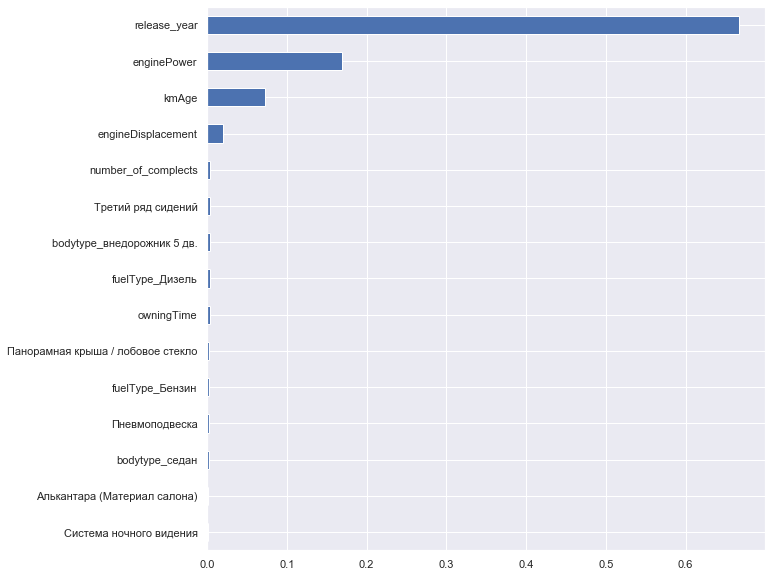

In [61]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh')

Самыми важными фичами оказались: год выпуска автомобиля, мощность двигателя (в л.с.), пробег, объём двигателя, количество различных характеристик в комплектации.

#### CatBoostRegressor

In [62]:
from catboost import CatBoostRegressor

# Настройки алгоритма
ITERATIONS = 2000
LR         = 0.1
DEPTH = 6

model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              depth = DEPTH,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED)

model.fit(X_train, y_train, 
          #cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=500,
          use_best_model=True,
          plot=False)

y_pred = model.predict(X_test)

print('MAPE:', mape(y_test, y_pred))

0:	learn: 1.0264444	test: 1.0384042	best: 1.0384042 (0)	total: 66ms	remaining: 2m 11s
500:	learn: 0.1253050	test: 0.1391574	best: 0.1391574 (500)	total: 8.9s	remaining: 26.6s
1000:	learn: 0.1080984	test: 0.1361080	best: 0.1360784 (990)	total: 17.7s	remaining: 17.6s
1500:	learn: 0.0961212	test: 0.1357577	best: 0.1355835 (1124)	total: 26.6s	remaining: 8.84s
1999:	learn: 0.0873694	test: 0.1364919	best: 0.1355835 (1124)	total: 34.8s	remaining: 0us

bestTest = 0.135583527
bestIteration = 1124

Shrink model to first 1125 iterations.
MAPE: 0.1355835269791103


#### LightGBM

Алгоритм не работает с не-ASCII названиями признаков, поэтому перед обучением закодируем названия столбцов в датасете:

In [63]:
columns = []

for i in range(X_train.shape[1]): 
    columns.append('col_'+ str(i)) 
    
X_train.columns = columns
X_test.columns = columns

In [64]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(n_jobs=-1,
                      tree_method='auto',
                      learning_rate=0.02,
                      max_depth=10,
                      #num_leaves = 600,
                      n_estimators=2000,
                      #colsample_bytree=0.8, 
                      #subsample=0.8, 
                      seed=42)

model.fit(X_train, y_train, eval_metric="mape")

y_pred = model.predict(X_test)

print('MAPE:', mape(y_test, y_pred))

MAPE: 0.13780275672565473


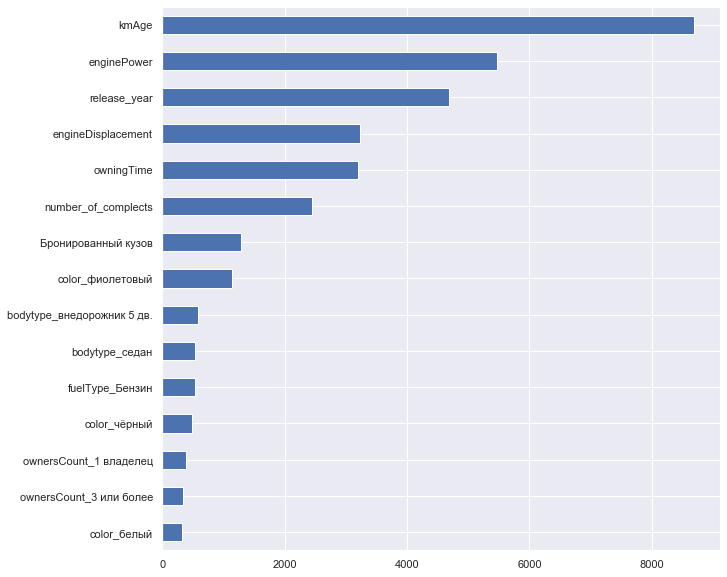

In [65]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh')

### 7. Выводы

Наиболее важными фичами для обучения модели оказались:
* год выпуска автомобиля
* пробег
* мощность двигателя
* объём двигателя
* время владения предыдущим владельцем
* комплектация автомобиля (количество дополнительных характеристик, указанных в комплектации)

Для определения ценового диапазона предлагается использовать метрику MAPE. Однако стоит обратить внимание на недостатки этой метрики - при одной и той же ошибке она жестче относится к повышенным прогнозам. Один из способ устранения данной проблемы - это предварительно логарифмировать значения цены перед обучением модели:

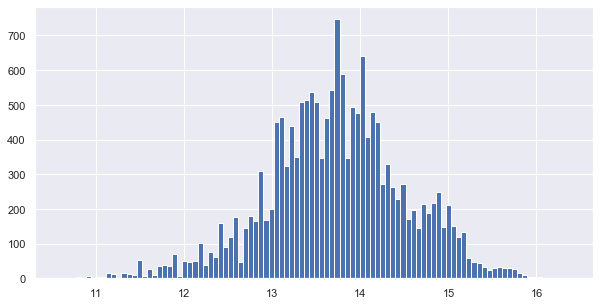

In [66]:
plt.rcParams['figure.figsize'] = (10,5)
np.log(data.price).hist(bins=100)

Распределение стало похоже на нормальное. Теперь заново обучим модель и посмотрим, каким будет MAPE:

In [70]:
y = np.log(data.price.values) 
X = data.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_SEED)

model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              depth = DEPTH,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED)

model.fit(X_train, y_train, 
          #cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=500,
          use_best_model=True,
          plot=False)

# не забудем вернуть значения в исходный вариант 

y_test = np.exp(y_test)
    
y_pred = np.exp(model.predict(X_test))

MAPE = mape(y_test, y_pred)
    
print('MAPE:', MAPE)

0:	learn: 0.0413570	test: 0.0418228	best: 0.0418228 (0)	total: 10.5ms	remaining: 21.1s
500:	learn: 0.0080700	test: 0.0094769	best: 0.0094769 (499)	total: 7.97s	remaining: 23.9s
1000:	learn: 0.0068599	test: 0.0093619	best: 0.0093616 (979)	total: 15.7s	remaining: 15.7s
1500:	learn: 0.0060898	test: 0.0093956	best: 0.0093566 (1056)	total: 23.4s	remaining: 7.76s
1999:	learn: 0.0055021	test: 0.0094439	best: 0.0093566 (1056)	total: 30.7s	remaining: 0us

bestTest = 0.009356567089
bestIteration = 1056

Shrink model to first 1057 iterations.
MAPE: 0.12758875967517705


Получили улучшение почти на 1%!

In [71]:
def price_predict(i):
    print('Цена в объявлении: {}'.format(df.price[i]))
    price_pred = np.exp(model.predict(data.drop('price', axis=1))[i])
    print('Price_min: {:.0f}'.format((1-MAPE)*price_pred))
    print('Price_max: {:.0f}'.format((1+MAPE)*price_pred))

In [72]:
price_predict(42)

Цена в объявлении: 615000
Price_min: 602176
Price_max: 778310
